In [7]:
from keras import backend as K

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import metrics
from keras.datasets import mnist

In [4]:
#整个网络的维度变化为：784->256->2->256->784
batch_size = 100
#原始输入维度，28*28=784
original_dim = 784
#编码后的code的维度
latent_dim = 2
#中间隐藏层的维度
intermediate_dim = 256
#迭代50次
epochs = 50
#初始化时的标准差
epsilon_std = 1.0

In [5]:
#编码器的结构
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
# mean vector
z_mean = Dense(latent_dim)(h)
# standard deviation vector
z_log_var = Dense(latent_dim)(h)

In [8]:
#使用均值变量（mean vector）和标准差变量（standard deviation vector）合成隐变量
def sampling(args):
    z_mean, z_log_var = args
    #使用标准正态分布初始化
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=epsilon_std)
    #合成公式
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
#z即为所要求得的隐含变量
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [9]:
# we instantiate these layers separately so as to reuse them later
# 解码器的结构
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
#x_decoded_mean 即为解码器输出的结果
x_decoded_mean = decoder_mean(h_decoded)

In [10]:
# Custom loss layer
#自定义损失层，损失包含两个部分：图片的重构误差（均方差Square Loss）以及隐变量与单位高斯分割之间的差异（KL-散度KL-Divergence Loss）。
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)#Square Loss
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)#KL-Divergence Loss
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [11]:
# train the VAE on MNIST digits
#使用MNIST数据集进行训练
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#图像数据归一化
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#将图像数据转换为784维的向量
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11493376/11490434 [==============================] - 6s 1us/step


In [14]:
#模型训练设置
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 137us/step - loss: 190.9941 - val_loss: 172.1404
Epoch 2/50
60000/60000 [==============================] - 8s 128us/step - loss: 170.0801 - val_loss: 167.6916
Epoch 3/50
60000/60000 [==============================] - 8s 133us/step - loss: 166.7017 - val_loss: 164.7282
Epoch 4/50
60000/60000 [==============================] - 7s 118us/step - loss: 164.2197 - val_loss: 162.9424
Epoch 5/50
60000/60000 [==============================] - 8s 134us/step - loss: 162.6909 - val_loss: 161.7155
Epoch 6/50
60000/60000 [==============================] - 8s 126us/step - loss: 161.6997 - val_loss: 161.7461
Epoch 7/50
60000/60000 [==============================] - 8s 138us/step - loss: 160.8861 - val_loss: 160.6286
Epoch 8/50
60000/60000 [==============================] - 7s 125us/step - loss: 160.2398 - val_loss: 160.0125
Epoch 9/50
60000/60000 [==============================] - 9s 150us/ste

In [15]:
#将损失层加入网络
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

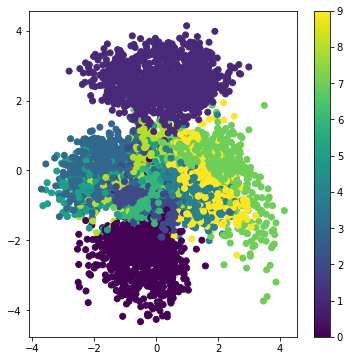

In [16]:
# build a model to project inputs on the latent space
#编码器的网络结构，将输入图形映射为code，即隐含变量
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
#将所有测试集中的图片通过encoder转换为隐含变量（二维变量），并将其在二维空间中进行绘图
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [17]:
# build a digit generator that can sample from the learned distribution
#构建一个解码器，用于将隐变量解码层图片
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [18]:
# display a 2D manifold of the digits
#绘制一个15个图像*15个图像的图
n = 15  # figure with 15x15 digits
#每个图像的大小为28*28
digit_size = 28
#初始化为0
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
# 生成因变量空间（二维）中的数据，数据满足高斯分布。这些数据构成隐变量，用于图像的生成。
#ppf为累积分布函数（cdf）的反函数，累积分布函数是概率密度函数（pdf）的积分。np.linspace(0.05, 0.95, n)为累计分布函数的输出值（y值），现在我们需要其对应的x值，所以使用cdf的反函数，这些x值构成隐变量。
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

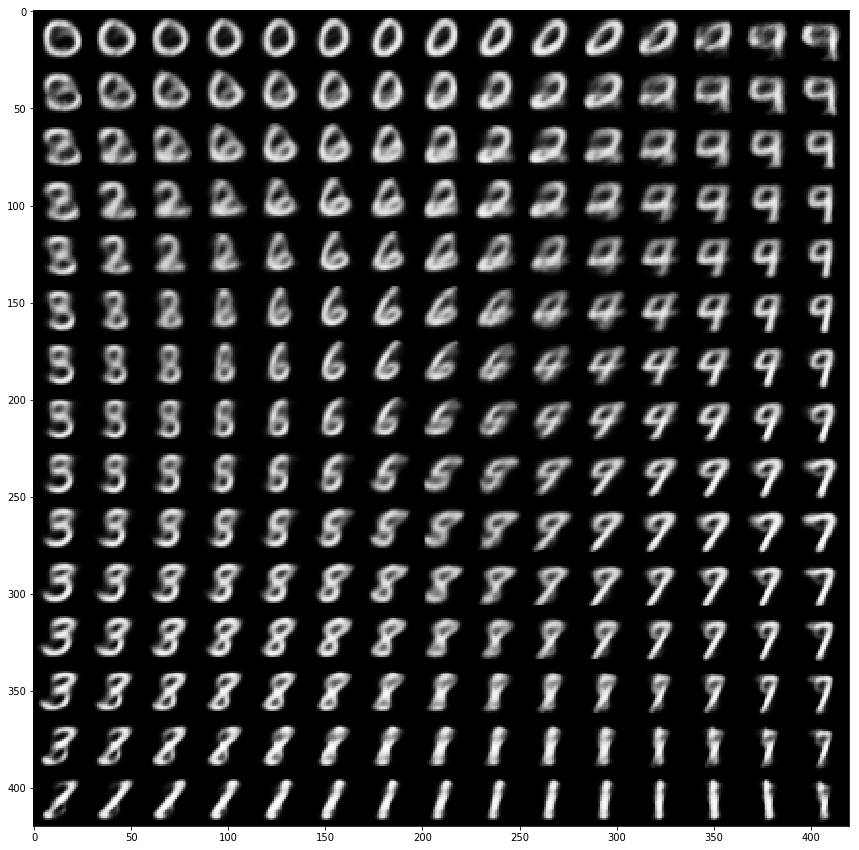

In [20]:
#绘图
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])#add by weihao: 1*2
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)#add by weihao: the generated image
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r')
plt.show()
